# Data Generation

The goal of this notebook is to write functions which generate data and evaluate the loss of particular controls.

## TODO Later

1. Write a python file with basic utils (generate data)

2. Write testing functions.

In [7]:
import numpy as np
np.random.seed(42)

In [8]:
#initial state is Gaussian mean 0, covariance sigma_0^2 I_m
#noise is Gaussian mean 0, covariance sigma_z^2 I_m
#cost 1 is k^2/m * squared l2 norm of u_1
# cost 2 is 1/m * squared l2 norm of x_2
def gen_initial_state(dimension, cov_term): 
    '''
    Generates a vector of dimension DIMENSION
    from a multivariate Gaussian distribution.
    Mean is always 0, and covariance is a scalar 
    multiple of the identity matrix.
    
    dimension: An positive integer. The dimension of the vector
    cov_term: A scalar to multiply the covariance matrix by. 
    '''
    return np.random.multivariate_normal(np.zeros(dimension), cov_term * np.eye(dimension))

In [9]:
def cost(control_1, x_2, k): 
    '''
    Cost function. 
    Input: 
    control_1: The u_1 vector
    x_2: The output after control 2
    k: A scalar term weighting the cost of control_1
    '''
    dim = len(control_1)
    return ((k**2)*np.linalg.norm(control_1)**2 + np.linalg.norm(x_2)**2) / dim

# Simple Neural Network 

## Training and Evaluation

Here I want to implement a simple, feedforward neural network which learns a map from $x_0$ to $u_1$. Once $u_1$ is given, we choose $u_2 = y_2$ based on conditional expectation maximization. That is, we claim that 

$$u_2^{*} = \arg \min_{u_{2}} \mathbb{E} [ \| x_2 \|_2^2 | Y_2 ] = y_2$$

The loss becomes 

$$\begin{eqnarray}
J = \frac{k^2}{m} \| u_1 \|_2^2 + \frac{1}{m} \| x_2 \|_2^2 \\
= k^2 u_1^2 + (x_0 + u_1 - u_2^{*})^{2} \\
= k^2 u_1^2 + (x_0 + u_1 - (x_0 + u_1 - z))^{2} \\
= k^2 u_1^2 + z^2 
\end{eqnarray}$$

Where $k \in \mathbb{R}$ is fixed and $z \sim N(0, \sigma_{z}^{2})$ is the noise to the second observation.

In [113]:
import keras 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
import keras.backend as K
from keras import optimizers

In [160]:
from keras.layers import Dense, Activation, Dropout, Conv2D, BatchNormalization

In [161]:
model_1_layer = keras.models.Sequential()
model_1_layer.add(Dense(30, activation='relu', input_shape=(None, 1)))
model_1_layer.add(Dense(1, activation='sigmoid'))
print(model_1_layer.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, None, 30)          60        
_________________________________________________________________
dense_33 (Dense)             (None, None, 1)           31        
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________
None


In [162]:
def first_control_loss(y_true, y_pred): 
    '''
    Here, y_true is unused. Just necessary for the Keras backend. 
    https://stackoverflow.com/questions/47639850/writing-a-custom-loss-function-without-y-true-in-keras
    y_pred is the network's prediction for the first controller. 
    
    We fix k^2 = 10 and variance of noise to be 1.
    '''
    return 10 * (y_pred ** 2) + np.random.normal()**2

Even though the loss function never uses a label, we still need dummy labels for the Keras functions to work. We'll pass in all zeros, but anything will do. 

In [163]:
model_1_layer.compile(optimizer='adam',
              loss=first_control_loss)

In [164]:
NUM_EPOCHS = 3000
NUM_TRAIN_SAMPLES = 25000
NUM_TEST_SAMPLES = 5000
x_train = np.array([gen_initial_state(1, 1) for _ in range(NUM_TRAIN_SAMPLES)])
x_train = x_train.reshape(1, x_train.shape[0], 1)
y_train = np.zeros(shape=(1, NUM_TRAIN_SAMPLES, 1))
validation_data = (np.array([gen_initial_state(1, 1) for _ in range(NUM_TEST_SAMPLES)]).reshape(1, NUM_TEST_SAMPLES, 1), 
                   np.zeros(shape=(1, NUM_TEST_SAMPLES, 1)))

In [165]:
train_history = model_1_layer.fit(x=x_train, y=y_train, 
                                  validation_data=validation_data, batch_size=16, 
                                  epochs=NUM_EPOCHS, verbose=1, shuffle=True)

Train on 1 samples, validate on 1 samples
Epoch 1/3000
1/1 [==============================] - 1s 518ms/step - loss: 3.4011 - val_loss: 3.3754
Epoch 2/3000
1/1 [==============================] - 0s 22ms/step - loss: 3.3796 - val_loss: 3.3540
Epoch 3/3000
1/1 [==============================] - 0s 26ms/step - loss: 3.3582 - val_loss: 3.3328
Epoch 4/3000
1/1 [==============================] - 0s 25ms/step - loss: 3.3369 - val_loss: 3.3117
Epoch 5/3000
1/1 [==============================] - 0s 18ms/step - loss: 3.3158 - val_loss: 3.2910
Epoch 6/3000
1/1 [==============================] - 0s 22ms/step - loss: 3.2950 - val_loss: 3.2704
Epoch 7/3000
1/1 [==============================] - 0s 22ms/step - loss: 3.2744 - val_loss: 3.2502
Epoch 8/3000
1/1 [==============================] - 0s 18ms/step - loss: 3.2540 - val_loss: 3.2301
Epoch 9/3000
1/1 [==============================] - 0s 24ms/step - loss: 3.2339 - val_loss: 3.2103
Epoch 10/3000
1/1 [==============================] - 0s 24ms/step 

Epoch 83/3000
1/1 [==============================] - 0s 16ms/step - loss: 2.0621 - val_loss: 2.0493
Epoch 84/3000
1/1 [==============================] - 0s 19ms/step - loss: 2.0499 - val_loss: 2.0371
Epoch 85/3000
1/1 [==============================] - 0s 19ms/step - loss: 2.0377 - val_loss: 2.0250
Epoch 86/3000
1/1 [==============================] - 0s 20ms/step - loss: 2.0255 - val_loss: 2.0130
Epoch 87/3000
1/1 [==============================] - 0s 19ms/step - loss: 2.0135 - val_loss: 2.0011
Epoch 88/3000
1/1 [==============================] - 0s 22ms/step - loss: 2.0016 - val_loss: 1.9893
Epoch 89/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.9899 - val_loss: 1.9777
Epoch 90/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.9782 - val_loss: 1.9661
Epoch 91/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.9666 - val_loss: 1.9547
Epoch 92/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.9552 - val_loss: 1.9433


Epoch 165/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.3929 - val_loss: 1.3883
Epoch 166/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.3884 - val_loss: 1.3838
Epoch 167/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.3839 - val_loss: 1.3794
Epoch 168/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.3795 - val_loss: 1.3751
Epoch 169/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.3752 - val_loss: 1.3708
Epoch 170/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.3709 - val_loss: 1.3666
Epoch 171/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.3667 - val_loss: 1.3625
Epoch 172/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.3626 - val_loss: 1.3584
Epoch 173/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.3585 - val_loss: 1.3544
Epoch 174/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.3545 - val_los

1/1 [==============================] - 0s 22ms/step - loss: 1.1747 - val_loss: 1.1732
Epoch 247/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.1733 - val_loss: 1.1718
Epoch 248/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.1719 - val_loss: 1.1704
Epoch 249/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.1705 - val_loss: 1.1690
Epoch 250/3000
1/1 [==============================] - 0s 27ms/step - loss: 1.1691 - val_loss: 1.1677
Epoch 251/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.1677 - val_loss: 1.1663
Epoch 252/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.1664 - val_loss: 1.1650
Epoch 253/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.1650 - val_loss: 1.1637
Epoch 254/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.1637 - val_loss: 1.1624
Epoch 255/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.1624 - val_loss: 1.1611
Epoch

Epoch 328/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.1001 - val_loss: 1.0995
Epoch 329/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0996 - val_loss: 1.0990
Epoch 330/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0990 - val_loss: 1.0985
Epoch 331/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0985 - val_loss: 1.0979
Epoch 332/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0980 - val_loss: 1.0974
Epoch 333/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0974 - val_loss: 1.0969
Epoch 334/3000
1/1 [==============================] - 0s 16ms/step - loss: 1.0969 - val_loss: 1.0964
Epoch 335/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0964 - val_loss: 1.0959
Epoch 336/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0959 - val_loss: 1.0954
Epoch 337/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0954 - val_los

1/1 [==============================] - 0s 21ms/step - loss: 1.0697 - val_loss: 1.0694
Epoch 410/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0694 - val_loss: 1.0692
Epoch 411/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0692 - val_loss: 1.0689
Epoch 412/3000
1/1 [==============================] - 0s 16ms/step - loss: 1.0689 - val_loss: 1.0687
Epoch 413/3000
1/1 [==============================] - 0s 16ms/step - loss: 1.0687 - val_loss: 1.0684
Epoch 414/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0684 - val_loss: 1.0682
Epoch 415/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0682 - val_loss: 1.0679
Epoch 416/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0679 - val_loss: 1.0677
Epoch 417/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0677 - val_loss: 1.0675
Epoch 418/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0675 - val_loss: 1.0672
Epoch

Epoch 491/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0545 - val_loss: 1.0544
Epoch 492/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0543 - val_loss: 1.0542
Epoch 493/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0542 - val_loss: 1.0541
Epoch 494/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0541 - val_loss: 1.0540
Epoch 495/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0540 - val_loss: 1.0538
Epoch 496/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0538 - val_loss: 1.0537
Epoch 497/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0537 - val_loss: 1.0536
Epoch 498/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0536 - val_loss: 1.0534
Epoch 499/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0534 - val_loss: 1.0533
Epoch 500/3000
1/1 [==============================] - 0s 26ms/step - loss: 1.0533 - val_los

1/1 [==============================] - 0s 18ms/step - loss: 1.0461 - val_loss: 1.0460
Epoch 573/3000
1/1 [==============================] - 0s 16ms/step - loss: 1.0460 - val_loss: 1.0459
Epoch 574/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0459 - val_loss: 1.0459
Epoch 575/3000
1/1 [==============================] - 0s 16ms/step - loss: 1.0459 - val_loss: 1.0458
Epoch 576/3000
1/1 [==============================] - 0s 15ms/step - loss: 1.0458 - val_loss: 1.0457
Epoch 577/3000
1/1 [==============================] - 0s 14ms/step - loss: 1.0457 - val_loss: 1.0456
Epoch 578/3000
1/1 [==============================] - 0s 15ms/step - loss: 1.0456 - val_loss: 1.0456
Epoch 579/3000
1/1 [==============================] - 0s 15ms/step - loss: 1.0456 - val_loss: 1.0455
Epoch 580/3000
1/1 [==============================] - 0s 15ms/step - loss: 1.0455 - val_loss: 1.0454
Epoch 581/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0454 - val_loss: 1.0453
Epoch

Epoch 654/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0409 - val_loss: 1.0409
Epoch 655/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0408 - val_loss: 1.0408
Epoch 656/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0408 - val_loss: 1.0408
Epoch 657/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0407 - val_loss: 1.0407
Epoch 658/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0407 - val_loss: 1.0407
Epoch 659/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0407 - val_loss: 1.0406
Epoch 660/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0406 - val_loss: 1.0406
Epoch 661/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0406 - val_loss: 1.0405
Epoch 662/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0405 - val_loss: 1.0405
Epoch 663/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0405 - val_los

1/1 [==============================] - 0s 24ms/step - loss: 1.0375 - val_loss: 1.0375
Epoch 736/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0375 - val_loss: 1.0375
Epoch 737/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0375 - val_loss: 1.0374
Epoch 738/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0374 - val_loss: 1.0374
Epoch 739/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0374 - val_loss: 1.0374
Epoch 740/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0374 - val_loss: 1.0373
Epoch 741/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0373 - val_loss: 1.0373
Epoch 742/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0373 - val_loss: 1.0373
Epoch 743/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0373 - val_loss: 1.0372
Epoch 744/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.0372 - val_loss: 1.0372
Epoch

Epoch 817/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0352 - val_loss: 1.0352
Epoch 818/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.0352 - val_loss: 1.0351
Epoch 819/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0351 - val_loss: 1.0351
Epoch 820/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0351 - val_loss: 1.0351
Epoch 821/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0351 - val_loss: 1.0351
Epoch 822/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0351 - val_loss: 1.0350
Epoch 823/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0350 - val_loss: 1.0350
Epoch 824/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0350 - val_loss: 1.0350
Epoch 825/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0350 - val_loss: 1.0350
Epoch 826/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.0350 - val_los

1/1 [==============================] - 0s 22ms/step - loss: 1.0335 - val_loss: 1.0335
Epoch 899/3000
1/1 [==============================] - 0s 29ms/step - loss: 1.0335 - val_loss: 1.0335
Epoch 900/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.0335 - val_loss: 1.0335
Epoch 901/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.0335 - val_loss: 1.0334
Epoch 902/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0334 - val_loss: 1.0334
Epoch 903/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.0334 - val_loss: 1.0334
Epoch 904/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0334 - val_loss: 1.0334
Epoch 905/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0334 - val_loss: 1.0334
Epoch 906/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0334 - val_loss: 1.0334
Epoch 907/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0334 - val_loss: 1.0333
Epoch

Epoch 980/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0323 - val_loss: 1.0322
Epoch 981/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0322 - val_loss: 1.0322
Epoch 982/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0322 - val_loss: 1.0322
Epoch 983/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0322 - val_loss: 1.0322
Epoch 984/3000
1/1 [==============================] - 0s 16ms/step - loss: 1.0322 - val_loss: 1.0322
Epoch 985/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0322 - val_loss: 1.0322
Epoch 986/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0322 - val_loss: 1.0322
Epoch 987/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0322 - val_loss: 1.0322
Epoch 988/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0321 - val_loss: 1.0321
Epoch 989/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0321 - val_los

Epoch 1061/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0313 - val_loss: 1.0313
Epoch 1062/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0313 - val_loss: 1.0313
Epoch 1063/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0313 - val_loss: 1.0313
Epoch 1064/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0313 - val_loss: 1.0313
Epoch 1065/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0313 - val_loss: 1.0313
Epoch 1066/3000
1/1 [==============================] - 0s 16ms/step - loss: 1.0313 - val_loss: 1.0312
Epoch 1067/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0312 - val_loss: 1.0312
Epoch 1068/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0312 - val_loss: 1.0312
Epoch 1069/3000
1/1 [==============================] - 0s 15ms/step - loss: 1.0312 - val_loss: 1.0312
Epoch 1070/3000
1/1 [==============================] - 0s 15ms/step - loss: 1.0312

Epoch 1142/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0306 - val_loss: 1.0306
Epoch 1143/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0306 - val_loss: 1.0306
Epoch 1144/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0305 - val_loss: 1.0305
Epoch 1145/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0305 - val_loss: 1.0305
Epoch 1146/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0305 - val_loss: 1.0305
Epoch 1147/3000
1/1 [==============================] - 0s 16ms/step - loss: 1.0305 - val_loss: 1.0305
Epoch 1148/3000
1/1 [==============================] - 0s 13ms/step - loss: 1.0305 - val_loss: 1.0305
Epoch 1149/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0305 - val_loss: 1.0305
Epoch 1150/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0305 - val_loss: 1.0305
Epoch 1151/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0305

Epoch 1223/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0300 - val_loss: 1.0300
Epoch 1224/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.0300 - val_loss: 1.0300
Epoch 1225/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0300 - val_loss: 1.0300
Epoch 1226/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0300 - val_loss: 1.0300
Epoch 1227/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0299 - val_loss: 1.0299
Epoch 1228/3000
1/1 [==============================] - 0s 30ms/step - loss: 1.0299 - val_loss: 1.0299
Epoch 1229/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.0299 - val_loss: 1.0299
Epoch 1230/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0299 - val_loss: 1.0299
Epoch 1231/3000
1/1 [==============================] - 0s 25ms/step - loss: 1.0299 - val_loss: 1.0299
Epoch 1232/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.0299

Epoch 1304/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0295 - val_loss: 1.0295
Epoch 1305/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0295 - val_loss: 1.0295
Epoch 1306/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0295 - val_loss: 1.0295
Epoch 1307/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0295 - val_loss: 1.0295
Epoch 1308/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0295 - val_loss: 1.0295
Epoch 1309/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0295 - val_loss: 1.0295
Epoch 1310/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0295 - val_loss: 1.0295
Epoch 1311/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0295 - val_loss: 1.0295
Epoch 1312/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.0295 - val_loss: 1.0295
Epoch 1313/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0294

Epoch 1385/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0291 - val_loss: 1.0291
Epoch 1386/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0291 - val_loss: 1.0291
Epoch 1387/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0291 - val_loss: 1.0291
Epoch 1388/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0291 - val_loss: 1.0291
Epoch 1389/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0291 - val_loss: 1.0291
Epoch 1390/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0291 - val_loss: 1.0291
Epoch 1391/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.0291 - val_loss: 1.0291
Epoch 1392/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0291 - val_loss: 1.0291
Epoch 1393/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0291 - val_loss: 1.0291
Epoch 1394/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0291

Epoch 1466/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.0288 - val_loss: 1.0288
Epoch 1467/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0288 - val_loss: 1.0288
Epoch 1468/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0288 - val_loss: 1.0288
Epoch 1469/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0288 - val_loss: 1.0288
Epoch 1470/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0288 - val_loss: 1.0288
Epoch 1471/3000
1/1 [==============================] - 0s 30ms/step - loss: 1.0288 - val_loss: 1.0288
Epoch 1472/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0287 - val_loss: 1.0288
Epoch 1473/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.0287 - val_loss: 1.0288
Epoch 1474/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0287 - val_loss: 1.0287
Epoch 1475/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0287

Epoch 1547/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0285 - val_loss: 1.0285
Epoch 1548/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0285 - val_loss: 1.0285
Epoch 1549/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0285 - val_loss: 1.0285
Epoch 1550/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0285 - val_loss: 1.0285
Epoch 1551/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0285 - val_loss: 1.0285
Epoch 1552/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0285 - val_loss: 1.0285
Epoch 1553/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0285 - val_loss: 1.0285
Epoch 1554/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0285 - val_loss: 1.0285
Epoch 1555/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0285 - val_loss: 1.0285
Epoch 1556/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0285

Epoch 1628/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0283 - val_loss: 1.0283
Epoch 1629/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0283 - val_loss: 1.0283
Epoch 1630/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0283 - val_loss: 1.0283
Epoch 1631/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0283 - val_loss: 1.0283
Epoch 1632/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0283 - val_loss: 1.0283
Epoch 1633/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.0283 - val_loss: 1.0283
Epoch 1634/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0283 - val_loss: 1.0283
Epoch 1635/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.0283 - val_loss: 1.0283
Epoch 1636/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0283 - val_loss: 1.0283
Epoch 1637/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0283

Epoch 1709/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0281 - val_loss: 1.0281
Epoch 1710/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0281 - val_loss: 1.0281
Epoch 1711/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0281 - val_loss: 1.0281
Epoch 1712/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0281 - val_loss: 1.0281
Epoch 1713/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0281 - val_loss: 1.0281
Epoch 1714/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0280 - val_loss: 1.0281
Epoch 1715/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0280 - val_loss: 1.0281
Epoch 1716/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0280 - val_loss: 1.0281
Epoch 1717/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.0280 - val_loss: 1.0281
Epoch 1718/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0280

Epoch 1790/3000
1/1 [==============================] - 0s 14ms/step - loss: 1.0279 - val_loss: 1.0279
Epoch 1791/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0279 - val_loss: 1.0279
Epoch 1792/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0279 - val_loss: 1.0279
Epoch 1793/3000
1/1 [==============================] - 0s 16ms/step - loss: 1.0279 - val_loss: 1.0279
Epoch 1794/3000
1/1 [==============================] - 0s 15ms/step - loss: 1.0279 - val_loss: 1.0279
Epoch 1795/3000
1/1 [==============================] - 0s 14ms/step - loss: 1.0279 - val_loss: 1.0279
Epoch 1796/3000
1/1 [==============================] - 0s 15ms/step - loss: 1.0279 - val_loss: 1.0279
Epoch 1797/3000
1/1 [==============================] - 0s 14ms/step - loss: 1.0279 - val_loss: 1.0279
Epoch 1798/3000
1/1 [==============================] - 0s 15ms/step - loss: 1.0279 - val_loss: 1.0279
Epoch 1799/3000
1/1 [==============================] - 0s 15ms/step - loss: 1.0279

Epoch 1871/3000
1/1 [==============================] - 0s 15ms/step - loss: 1.0277 - val_loss: 1.0278
Epoch 1872/3000
1/1 [==============================] - 0s 15ms/step - loss: 1.0277 - val_loss: 1.0278
Epoch 1873/3000
1/1 [==============================] - 0s 14ms/step - loss: 1.0277 - val_loss: 1.0278
Epoch 1874/3000
1/1 [==============================] - 0s 16ms/step - loss: 1.0277 - val_loss: 1.0278
Epoch 1875/3000
1/1 [==============================] - 0s 15ms/step - loss: 1.0277 - val_loss: 1.0277
Epoch 1876/3000
1/1 [==============================] - 0s 14ms/step - loss: 1.0277 - val_loss: 1.0277
Epoch 1877/3000
1/1 [==============================] - 0s 16ms/step - loss: 1.0277 - val_loss: 1.0277
Epoch 1878/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0277 - val_loss: 1.0277
Epoch 1879/3000
1/1 [==============================] - 0s 16ms/step - loss: 1.0277 - val_loss: 1.0277
Epoch 1880/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0277

Epoch 1952/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0276 - val_loss: 1.0276
Epoch 1953/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.0276 - val_loss: 1.0276
Epoch 1954/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0276 - val_loss: 1.0276
Epoch 1955/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0276 - val_loss: 1.0276
Epoch 1956/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0276 - val_loss: 1.0276
Epoch 1957/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0276 - val_loss: 1.0276
Epoch 1958/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0276 - val_loss: 1.0276
Epoch 1959/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0276 - val_loss: 1.0276
Epoch 1960/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0276 - val_loss: 1.0276
Epoch 1961/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0276

Epoch 2033/3000
1/1 [==============================] - 0s 16ms/step - loss: 1.0275 - val_loss: 1.0275
Epoch 2034/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0275 - val_loss: 1.0275
Epoch 2035/3000
1/1 [==============================] - 0s 16ms/step - loss: 1.0275 - val_loss: 1.0275
Epoch 2036/3000
1/1 [==============================] - 0s 15ms/step - loss: 1.0275 - val_loss: 1.0275
Epoch 2037/3000
1/1 [==============================] - 0s 15ms/step - loss: 1.0275 - val_loss: 1.0275
Epoch 2038/3000
1/1 [==============================] - 0s 15ms/step - loss: 1.0275 - val_loss: 1.0275
Epoch 2039/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0275 - val_loss: 1.0275
Epoch 2040/3000
1/1 [==============================] - 0s 16ms/step - loss: 1.0275 - val_loss: 1.0275
Epoch 2041/3000
1/1 [==============================] - 0s 15ms/step - loss: 1.0275 - val_loss: 1.0275
Epoch 2042/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0275

Epoch 2114/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0274 - val_loss: 1.0274
Epoch 2115/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0274 - val_loss: 1.0274
Epoch 2116/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0274 - val_loss: 1.0274
Epoch 2117/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0274 - val_loss: 1.0274
Epoch 2118/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0274 - val_loss: 1.0274
Epoch 2119/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0274 - val_loss: 1.0274
Epoch 2120/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0274 - val_loss: 1.0274
Epoch 2121/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0274 - val_loss: 1.0274
Epoch 2122/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0274 - val_loss: 1.0274
Epoch 2123/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0274

Epoch 2195/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0273 - val_loss: 1.0273
Epoch 2196/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0273 - val_loss: 1.0273
Epoch 2197/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0273 - val_loss: 1.0273
Epoch 2198/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0273 - val_loss: 1.0273
Epoch 2199/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0273 - val_loss: 1.0273
Epoch 2200/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0273 - val_loss: 1.0273
Epoch 2201/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0273 - val_loss: 1.0273
Epoch 2202/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.0273 - val_loss: 1.0273
Epoch 2203/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0273 - val_loss: 1.0273
Epoch 2204/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0273

Epoch 2276/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0273 - val_loss: 1.0272
Epoch 2277/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0273 - val_loss: 1.0272
Epoch 2278/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0273 - val_loss: 1.0272
Epoch 2279/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0273 - val_loss: 1.0272
Epoch 2280/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0273 - val_loss: 1.0272
Epoch 2281/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0273 - val_loss: 1.0272
Epoch 2282/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0273 - val_loss: 1.0272
Epoch 2283/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0273 - val_loss: 1.0272
Epoch 2284/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0273 - val_loss: 1.0272
Epoch 2285/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0272

Epoch 2357/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0272 - val_loss: 1.0272
Epoch 2358/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0272 - val_loss: 1.0272
Epoch 2359/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0272 - val_loss: 1.0272
Epoch 2360/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0272 - val_loss: 1.0272
Epoch 2361/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0272 - val_loss: 1.0272
Epoch 2362/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0272 - val_loss: 1.0272
Epoch 2363/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0272 - val_loss: 1.0272
Epoch 2364/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0272 - val_loss: 1.0272
Epoch 2365/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0272 - val_loss: 1.0272
Epoch 2366/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0271

Epoch 2438/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0271 - val_loss: 1.0271
Epoch 2439/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0271 - val_loss: 1.0271
Epoch 2440/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0271 - val_loss: 1.0271
Epoch 2441/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0271 - val_loss: 1.0271
Epoch 2442/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0271 - val_loss: 1.0271
Epoch 2443/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0271 - val_loss: 1.0271
Epoch 2444/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0271 - val_loss: 1.0271
Epoch 2445/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0271 - val_loss: 1.0271
Epoch 2446/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0271 - val_loss: 1.0271
Epoch 2447/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0271

Epoch 2519/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0270 - val_loss: 1.0271
Epoch 2520/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0270 - val_loss: 1.0271
Epoch 2521/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0270 - val_loss: 1.0271
Epoch 2522/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0270 - val_loss: 1.0271
Epoch 2523/3000
1/1 [==============================] - 0s 24ms/step - loss: 1.0270 - val_loss: 1.0271
Epoch 2524/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0270 - val_loss: 1.0270
Epoch 2525/3000
1/1 [==============================] - 0s 32ms/step - loss: 1.0270 - val_loss: 1.0270
Epoch 2526/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0270 - val_loss: 1.0270
Epoch 2527/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.0270 - val_loss: 1.0270
Epoch 2528/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0270

Epoch 2600/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0270 - val_loss: 1.0270
Epoch 2601/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0270 - val_loss: 1.0270
Epoch 2602/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0270 - val_loss: 1.0270
Epoch 2603/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0270 - val_loss: 1.0270
Epoch 2604/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0270 - val_loss: 1.0270
Epoch 2605/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0270 - val_loss: 1.0270
Epoch 2606/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0270 - val_loss: 1.0270
Epoch 2607/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0270 - val_loss: 1.0270
Epoch 2608/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0270 - val_loss: 1.0270
Epoch 2609/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0270

Epoch 2681/3000
1/1 [==============================] - 0s 16ms/step - loss: 1.0270 - val_loss: 1.0270
Epoch 2682/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0270 - val_loss: 1.0270
Epoch 2683/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0270 - val_loss: 1.0270
Epoch 2684/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0270 - val_loss: 1.0270
Epoch 2685/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0270 - val_loss: 1.0270
Epoch 2686/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0270 - val_loss: 1.0270
Epoch 2687/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0270 - val_loss: 1.0270
Epoch 2688/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0270 - val_loss: 1.0270
Epoch 2689/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0270 - val_loss: 1.0270
Epoch 2690/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0270

Epoch 2762/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0269 - val_loss: 1.0269
Epoch 2763/3000
1/1 [==============================] - 0s 23ms/step - loss: 1.0269 - val_loss: 1.0269
Epoch 2764/3000
1/1 [==============================] - 0s 16ms/step - loss: 1.0269 - val_loss: 1.0269
Epoch 2765/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0269 - val_loss: 1.0269
Epoch 2766/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0269 - val_loss: 1.0269
Epoch 2767/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0269 - val_loss: 1.0269
Epoch 2768/3000
1/1 [==============================] - 0s 16ms/step - loss: 1.0269 - val_loss: 1.0269
Epoch 2769/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0269 - val_loss: 1.0269
Epoch 2770/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0269 - val_loss: 1.0269
Epoch 2771/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0269

Epoch 2843/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0269 - val_loss: 1.0269
Epoch 2844/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0269 - val_loss: 1.0269
Epoch 2845/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0269 - val_loss: 1.0269
Epoch 2846/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0269 - val_loss: 1.0269
Epoch 2847/3000
1/1 [==============================] - 0s 22ms/step - loss: 1.0269 - val_loss: 1.0269
Epoch 2848/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0269 - val_loss: 1.0269
Epoch 2849/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0269 - val_loss: 1.0269
Epoch 2850/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0269 - val_loss: 1.0269
Epoch 2851/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0269 - val_loss: 1.0269
Epoch 2852/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0269

Epoch 2924/3000
1/1 [==============================] - 0s 18ms/step - loss: 1.0268 - val_loss: 1.0268
Epoch 2925/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0268 - val_loss: 1.0268
Epoch 2926/3000
1/1 [==============================] - 0s 17ms/step - loss: 1.0268 - val_loss: 1.0268
Epoch 2927/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0268 - val_loss: 1.0268
Epoch 2928/3000
1/1 [==============================] - 0s 21ms/step - loss: 1.0268 - val_loss: 1.0268
Epoch 2929/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0268 - val_loss: 1.0268
Epoch 2930/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0268 - val_loss: 1.0268
Epoch 2931/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0268 - val_loss: 1.0268
Epoch 2932/3000
1/1 [==============================] - 0s 19ms/step - loss: 1.0268 - val_loss: 1.0268
Epoch 2933/3000
1/1 [==============================] - 0s 20ms/step - loss: 1.0268

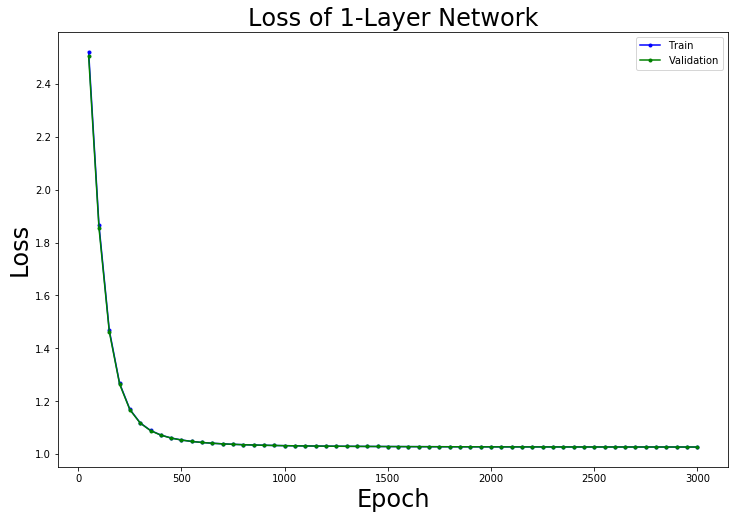

In [166]:
train_losses = np.array(train_history.history['loss'])
val_losses = np.array(train_history.history['val_loss'])

epoch_step = 50
plot_train_losses = train_losses[[np.arange(1, NUM_EPOCHS + 1) % epoch_step == 0]]
plot_val_losses = val_losses[[np.arange(1, NUM_EPOCHS + 1) % epoch_step == 0]]

plot_x_arr = np.arange(1, NUM_EPOCHS + 1)[np.arange(1, NUM_EPOCHS + 1) % epoch_step == 0]

plt.figure(figsize=(12, 8))

plt.plot(plot_x_arr, plot_train_losses, '.-', c='blue', label='Train')
plt.plot(plot_x_arr, plot_val_losses, '.-', c='green', label='Validation')
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Loss', fontsize=24)
plt.legend()
plt.title('Loss of 1-Layer Network', fontsize=24);
plt.savefig('figs/better-history-1-layer-nn.png');

The model seems to "max out" around 1,000 epochs although still slowly improves for the last 2,000 epochs. I expect that we'd see this behavior continue for indefinitely long training. 

As expected, the lowest possible loss is at $1.0$. This is because the loss is $k^2 u_1^2 + z^2$ and $Var(z) = E(z^2) = 1$. If we set the variance of the noise to be different, the floor in loss would reflect that. 

Also: "validation" loss here might be misleading, since there are no actual labels in the training process. We just input dummy labels and a custom loss function which does not depend on the label at all. This *explains why validation and training loss are virtually identical*.

## Further Exploration

First, let's plot $x_0$ vs $x_1$, where $x_1 = x_0 + u_1$. 

In [168]:
plt.rcParams['figure.figsize'] = [12.0, 8.0]

In [170]:
x_0 = np.linspace(-4, 4, 500)

In [172]:
u_1_pred = model_1_layer.predict(x_0.reshape(1, 500, 1))

In [184]:
x_1 = x_0 + u_1_pred[0][:, 0]

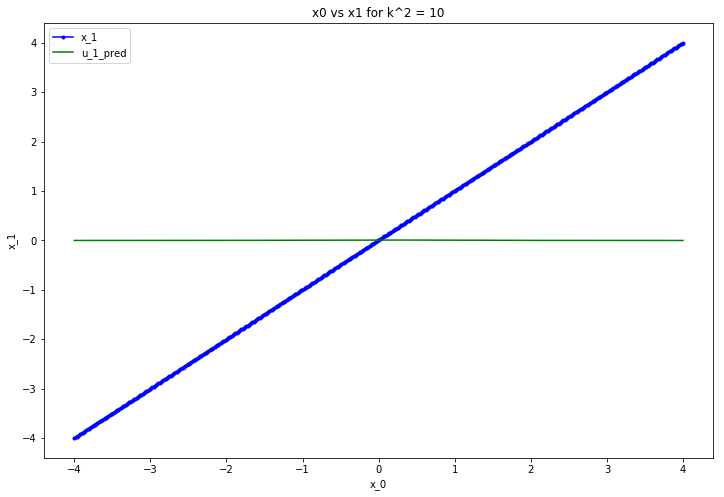

In [286]:
plt.plot(x_0, x_1, '.-', label='x_1', color='blue')
plt.plot(x_0, u_1_pred[0][:, 0], label='u_1_pred', color='green')
plt.xlabel('x_0')
plt.ylabel('x_1')
plt.title('x0 vs x1 for k^2 = 10')
plt.legend()

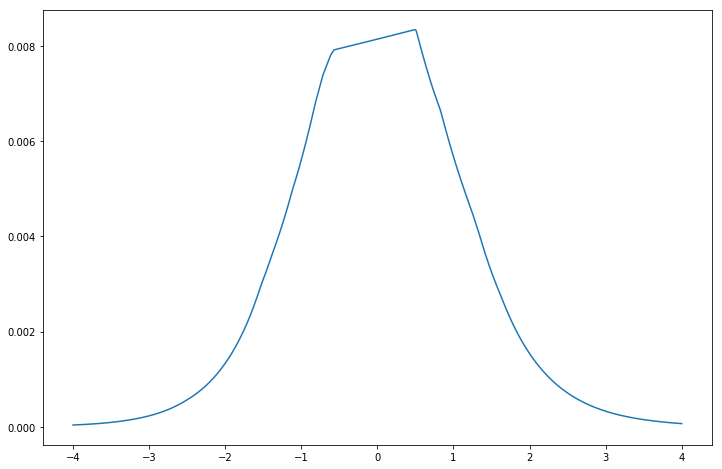

In [194]:
plt.plot(x_0, u_1_pred[0][:, 0])

## X_0 vs X_1 with k^2 = 0.5

We didn't get the same behavior as Fig. 6(a) in the above plots. Maybe this is because we set $k^2 = 10$. The paper used $k^2 = 0.5$ so let's try that out.

In [272]:
def first_control_loss(y_true, y_pred): 
    '''
    Here, y_true is unused. Just necessary for the Keras backend. 
    https://stackoverflow.com/questions/47639850/writing-a-custom-loss-function-without-y-true-in-keras
    y_pred is the network's prediction for the first controller. 
    
    We fix k^2 = 10 and variance of noise to be 1.
    '''
    k_squared = 0.5 #code is different here
    return (k_squared * (y_pred**2)) + np.random.normal()**2

**Note**: I ran the following code several times, and sometimes the initialization would get lucky and the loss would be below 1. Why is this happening? Given that the variance of the noise is $1$, this should be a lower bound on the loss. 

In [273]:
model_simple = keras.models.Sequential()
model_simple.add(Dense(30, activation='relu', input_shape=(None, 1)))
model_simple.add(Dense(1, activation='sigmoid'))
print(model_simple.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, None, 30)          60        
_________________________________________________________________
dense_63 (Dense)             (None, None, 1)           31        
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________
None


In [274]:
model_simple.compile(optimizer='adam',
              loss=first_control_loss)

In [277]:
NUM_EPOCHS = 800

In [278]:
simple_train_history = model_simple.fit(x=x_train, y=y_train, 
                                  validation_data=validation_data, batch_size=16, 
                                  epochs=NUM_EPOCHS, verbose=1, shuffle=True)

Train on 1 samples, validate on 1 samples
Epoch 1/800
1/1 [==============================] - 0s 41ms/step - loss: 0.4813 - val_loss: 0.4806
Epoch 2/800
1/1 [==============================] - 0s 25ms/step - loss: 0.4806 - val_loss: 0.4799
Epoch 3/800
1/1 [==============================] - 0s 21ms/step - loss: 0.4798 - val_loss: 0.4792
Epoch 4/800
1/1 [==============================] - 0s 22ms/step - loss: 0.4791 - val_loss: 0.4785
Epoch 5/800
1/1 [==============================] - 0s 32ms/step - loss: 0.4784 - val_loss: 0.4778
Epoch 6/800
1/1 [==============================] - 0s 25ms/step - loss: 0.4777 - val_loss: 0.4771
Epoch 7/800
1/1 [==============================] - 0s 19ms/step - loss: 0.4770 - val_loss: 0.4764
Epoch 8/800
1/1 [==============================] - 0s 18ms/step - loss: 0.4763 - val_loss: 0.4757
Epoch 9/800
1/1 [==============================] - 0s 17ms/step - loss: 0.4756 - val_loss: 0.4750
Epoch 10/800
1/1 [==============================] - 0s 16ms/step - loss: 0.4

Epoch 84/800
1/1 [==============================] - 0s 19ms/step - loss: 0.4366 - val_loss: 0.4362
Epoch 85/800
1/1 [==============================] - 0s 21ms/step - loss: 0.4362 - val_loss: 0.4358
Epoch 86/800
1/1 [==============================] - 0s 21ms/step - loss: 0.4359 - val_loss: 0.4355
Epoch 87/800
1/1 [==============================] - 0s 21ms/step - loss: 0.4355 - val_loss: 0.4351
Epoch 88/800
1/1 [==============================] - 0s 23ms/step - loss: 0.4352 - val_loss: 0.4348
Epoch 89/800
1/1 [==============================] - 0s 20ms/step - loss: 0.4348 - val_loss: 0.4344
Epoch 90/800
1/1 [==============================] - 0s 17ms/step - loss: 0.4345 - val_loss: 0.4341
Epoch 91/800
1/1 [==============================] - 0s 16ms/step - loss: 0.4341 - val_loss: 0.4337
Epoch 92/800
1/1 [==============================] - 0s 17ms/step - loss: 0.4338 - val_loss: 0.4334
Epoch 93/800
1/1 [==============================] - 0s 19ms/step - loss: 0.4334 - val_loss: 0.4331
Epoch 94/8

1/1 [==============================] - 0s 19ms/step - loss: 0.4168 - val_loss: 0.4167
Epoch 167/800
1/1 [==============================] - 0s 19ms/step - loss: 0.4167 - val_loss: 0.4165
Epoch 168/800
1/1 [==============================] - 0s 17ms/step - loss: 0.4166 - val_loss: 0.4164
Epoch 169/800
1/1 [==============================] - 0s 18ms/step - loss: 0.4164 - val_loss: 0.4163
Epoch 170/800
1/1 [==============================] - 0s 17ms/step - loss: 0.4163 - val_loss: 0.4161
Epoch 171/800
1/1 [==============================] - 0s 16ms/step - loss: 0.4162 - val_loss: 0.4160
Epoch 172/800
1/1 [==============================] - 0s 17ms/step - loss: 0.4160 - val_loss: 0.4159
Epoch 173/800
1/1 [==============================] - 0s 18ms/step - loss: 0.4159 - val_loss: 0.4158
Epoch 174/800
1/1 [==============================] - 0s 20ms/step - loss: 0.4158 - val_loss: 0.4156
Epoch 175/800
1/1 [==============================] - 0s 17ms/step - loss: 0.4157 - val_loss: 0.4155
Epoch 176/800


1/1 [==============================] - 0s 20ms/step - loss: 0.4099 - val_loss: 0.4098
Epoch 249/800
1/1 [==============================] - 0s 18ms/step - loss: 0.4098 - val_loss: 0.4098
Epoch 250/800
1/1 [==============================] - 0s 19ms/step - loss: 0.4098 - val_loss: 0.4097
Epoch 251/800
1/1 [==============================] - 0s 19ms/step - loss: 0.4097 - val_loss: 0.4097
Epoch 252/800
1/1 [==============================] - 0s 20ms/step - loss: 0.4097 - val_loss: 0.4096
Epoch 253/800
1/1 [==============================] - 0s 19ms/step - loss: 0.4096 - val_loss: 0.4096
Epoch 254/800
1/1 [==============================] - 0s 17ms/step - loss: 0.4096 - val_loss: 0.4096
Epoch 255/800
1/1 [==============================] - 0s 16ms/step - loss: 0.4096 - val_loss: 0.4095
Epoch 256/800
1/1 [==============================] - 0s 16ms/step - loss: 0.4095 - val_loss: 0.4095
Epoch 257/800
1/1 [==============================] - 0s 19ms/step - loss: 0.4095 - val_loss: 0.4094
Epoch 258/800


1/1 [==============================] - 0s 18ms/step - loss: 0.4073 - val_loss: 0.4073
Epoch 331/800
1/1 [==============================] - 0s 19ms/step - loss: 0.4073 - val_loss: 0.4073
Epoch 332/800
1/1 [==============================] - 0s 18ms/step - loss: 0.4073 - val_loss: 0.4073
Epoch 333/800
1/1 [==============================] - 0s 20ms/step - loss: 0.4073 - val_loss: 0.4073
Epoch 334/800
1/1 [==============================] - 0s 18ms/step - loss: 0.4073 - val_loss: 0.4073
Epoch 335/800
1/1 [==============================] - 0s 18ms/step - loss: 0.4073 - val_loss: 0.4072
Epoch 336/800
1/1 [==============================] - 0s 17ms/step - loss: 0.4072 - val_loss: 0.4072
Epoch 337/800
1/1 [==============================] - 0s 18ms/step - loss: 0.4072 - val_loss: 0.4072
Epoch 338/800
1/1 [==============================] - 0s 17ms/step - loss: 0.4072 - val_loss: 0.4072
Epoch 339/800
1/1 [==============================] - 0s 17ms/step - loss: 0.4072 - val_loss: 0.4072
Epoch 340/800


1/1 [==============================] - 0s 18ms/step - loss: 0.4062 - val_loss: 0.4062
Epoch 413/800
1/1 [==============================] - 0s 17ms/step - loss: 0.4062 - val_loss: 0.4062
Epoch 414/800
1/1 [==============================] - 0s 19ms/step - loss: 0.4062 - val_loss: 0.4062
Epoch 415/800
1/1 [==============================] - 0s 18ms/step - loss: 0.4062 - val_loss: 0.4062
Epoch 416/800
1/1 [==============================] - 0s 17ms/step - loss: 0.4062 - val_loss: 0.4062
Epoch 417/800
1/1 [==============================] - 0s 19ms/step - loss: 0.4062 - val_loss: 0.4062
Epoch 418/800
1/1 [==============================] - 0s 19ms/step - loss: 0.4062 - val_loss: 0.4062
Epoch 419/800
1/1 [==============================] - 0s 18ms/step - loss: 0.4062 - val_loss: 0.4062
Epoch 420/800
1/1 [==============================] - 0s 20ms/step - loss: 0.4062 - val_loss: 0.4062
Epoch 421/800
1/1 [==============================] - 0s 20ms/step - loss: 0.4062 - val_loss: 0.4062
Epoch 422/800


1/1 [==============================] - 0s 18ms/step - loss: 0.4057 - val_loss: 0.4057
Epoch 495/800
1/1 [==============================] - 0s 15ms/step - loss: 0.4057 - val_loss: 0.4057
Epoch 496/800
1/1 [==============================] - 0s 15ms/step - loss: 0.4057 - val_loss: 0.4057
Epoch 497/800
1/1 [==============================] - 0s 14ms/step - loss: 0.4057 - val_loss: 0.4057
Epoch 498/800
1/1 [==============================] - 0s 17ms/step - loss: 0.4057 - val_loss: 0.4057
Epoch 499/800
1/1 [==============================] - 0s 17ms/step - loss: 0.4057 - val_loss: 0.4057
Epoch 500/800
1/1 [==============================] - 0s 17ms/step - loss: 0.4057 - val_loss: 0.4056
Epoch 501/800
1/1 [==============================] - 0s 18ms/step - loss: 0.4056 - val_loss: 0.4056
Epoch 502/800
1/1 [==============================] - 0s 17ms/step - loss: 0.4056 - val_loss: 0.4056
Epoch 503/800
1/1 [==============================] - 0s 20ms/step - loss: 0.4056 - val_loss: 0.4056
Epoch 504/800


1/1 [==============================] - 0s 24ms/step - loss: 0.4054 - val_loss: 0.4054
Epoch 577/800
1/1 [==============================] - 0s 34ms/step - loss: 0.4054 - val_loss: 0.4054
Epoch 578/800
1/1 [==============================] - 0s 20ms/step - loss: 0.4054 - val_loss: 0.4053
Epoch 579/800
1/1 [==============================] - 0s 20ms/step - loss: 0.4053 - val_loss: 0.4053
Epoch 580/800
1/1 [==============================] - 0s 21ms/step - loss: 0.4053 - val_loss: 0.4053
Epoch 581/800
1/1 [==============================] - 0s 16ms/step - loss: 0.4053 - val_loss: 0.4053
Epoch 582/800
1/1 [==============================] - 0s 15ms/step - loss: 0.4053 - val_loss: 0.4053
Epoch 583/800
1/1 [==============================] - 0s 21ms/step - loss: 0.4053 - val_loss: 0.4053
Epoch 584/800
1/1 [==============================] - 0s 19ms/step - loss: 0.4053 - val_loss: 0.4053
Epoch 585/800
1/1 [==============================] - 0s 19ms/step - loss: 0.4053 - val_loss: 0.4053
Epoch 586/800


1/1 [==============================] - 0s 17ms/step - loss: 0.4052 - val_loss: 0.4052
Epoch 659/800
1/1 [==============================] - 0s 18ms/step - loss: 0.4052 - val_loss: 0.4052
Epoch 660/800
1/1 [==============================] - 0s 18ms/step - loss: 0.4052 - val_loss: 0.4052
Epoch 661/800
1/1 [==============================] - 0s 17ms/step - loss: 0.4052 - val_loss: 0.4051
Epoch 662/800
1/1 [==============================] - 0s 19ms/step - loss: 0.4051 - val_loss: 0.4051
Epoch 663/800
1/1 [==============================] - 0s 18ms/step - loss: 0.4051 - val_loss: 0.4051
Epoch 664/800
1/1 [==============================] - 0s 17ms/step - loss: 0.4051 - val_loss: 0.4051
Epoch 665/800
1/1 [==============================] - 0s 18ms/step - loss: 0.4051 - val_loss: 0.4051
Epoch 666/800
1/1 [==============================] - 0s 15ms/step - loss: 0.4051 - val_loss: 0.4051
Epoch 667/800
1/1 [==============================] - 0s 17ms/step - loss: 0.4051 - val_loss: 0.4051
Epoch 668/800


1/1 [==============================] - 0s 18ms/step - loss: 0.4050 - val_loss: 0.4050
Epoch 741/800
1/1 [==============================] - 0s 19ms/step - loss: 0.4050 - val_loss: 0.4050
Epoch 742/800
1/1 [==============================] - 0s 17ms/step - loss: 0.4050 - val_loss: 0.4050
Epoch 743/800
1/1 [==============================] - 0s 16ms/step - loss: 0.4050 - val_loss: 0.4050
Epoch 744/800
1/1 [==============================] - 0s 20ms/step - loss: 0.4050 - val_loss: 0.4050
Epoch 745/800
1/1 [==============================] - 0s 18ms/step - loss: 0.4050 - val_loss: 0.4050
Epoch 746/800
1/1 [==============================] - 0s 19ms/step - loss: 0.4050 - val_loss: 0.4050
Epoch 747/800
1/1 [==============================] - 0s 19ms/step - loss: 0.4050 - val_loss: 0.4050
Epoch 748/800
1/1 [==============================] - 0s 17ms/step - loss: 0.4050 - val_loss: 0.4050
Epoch 749/800
1/1 [==============================] - 0s 20ms/step - loss: 0.4050 - val_loss: 0.4050
Epoch 750/800


In [279]:
u1_pred = model_simple.predict(x_0.reshape(1, 500, 1))

In [280]:
u1_pred

array([[[ 0.00028076],
        [ 0.00028756],
        [ 0.00029452],
        [ 0.00030165],
        [ 0.00030896],
        [ 0.00031644],
        [ 0.0003241 ],
        [ 0.00033195],
        [ 0.00033999],
        [ 0.00034822],
        [ 0.00035666],
        [ 0.00036529],
        [ 0.00037414],
        [ 0.0003832 ],
        [ 0.00039248],
        [ 0.00040198],
        [ 0.00041172],
        [ 0.00042168],
        [ 0.0004319 ],
        [ 0.00044235],
        [ 0.00045306],
        [ 0.00046403],
        [ 0.00047527],
        [ 0.00048678],
        [ 0.00049856],
        [ 0.00051064],
        [ 0.000523  ],
        [ 0.00053566],
        [ 0.00054863],
        [ 0.00056191],
        [ 0.00057552],
        [ 0.00058945],
        [ 0.00060372],
        [ 0.00061834],
        [ 0.00063331],
        [ 0.00064864],
        [ 0.00066434],
        [ 0.00068042],
        [ 0.00069689],
        [ 0.00071377],
        [ 0.00073104],
        [ 0.00074874],
        [ 0.00076686],
        [ 0

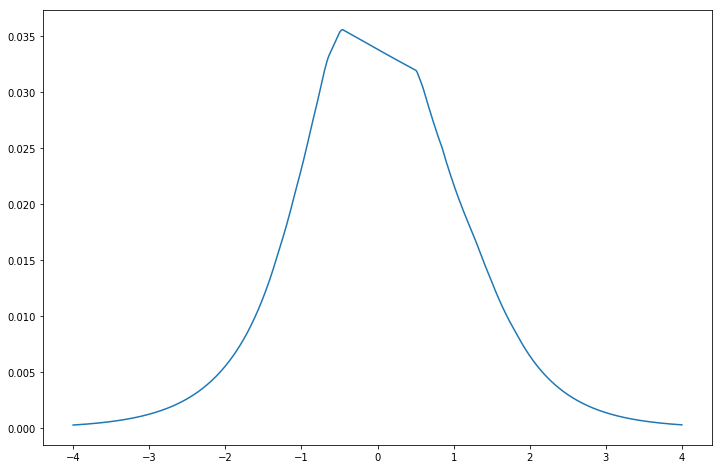

In [281]:
plt.plot(x_0, u1_pred[0][:, 0])

In [282]:
x1_pred = x_0 + u1_pred[0][:, 0]

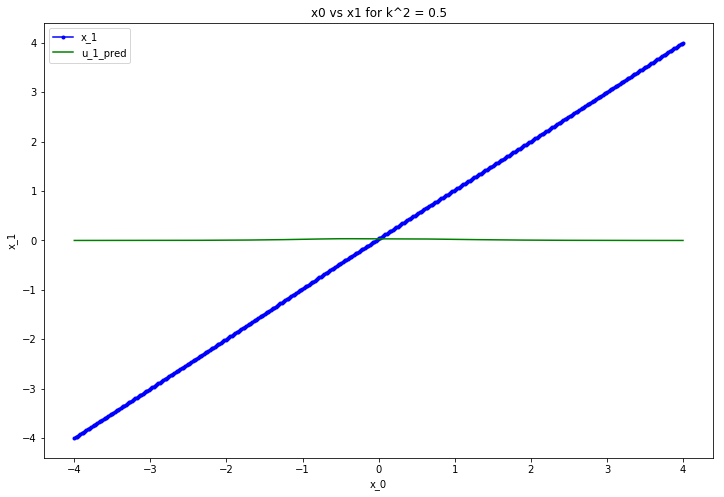

In [284]:
plt.plot(x_0, x1_pred, '.-', label='x_1', color='blue')
plt.plot(x_0, u1_pred[0][:, 0], label='u_1_pred', color='green')
plt.xlabel('x_0')
plt.ylabel('x_1')
plt.title('x0 vs x1 for k^2 = 0.5')
plt.legend()